# Tutorial Warning Class

In [1]:
import numpy as np
from scipy import sparse
from climada_petals.engine.warn import Warn
from climada.util.plot import geo_scatter_categorical
import xarray as xr



# MCH Example

array([<GeoAxesSubplot:title={'center':'Warning'}>], dtype=object)

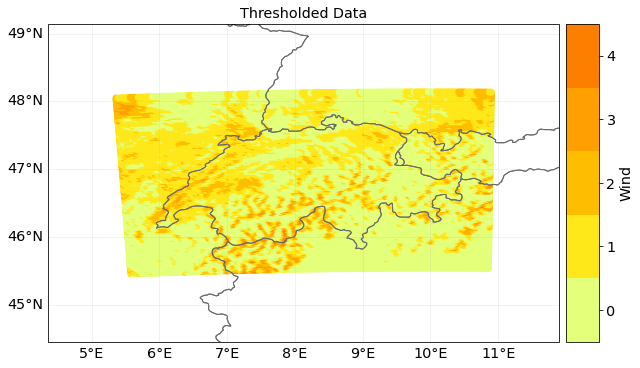

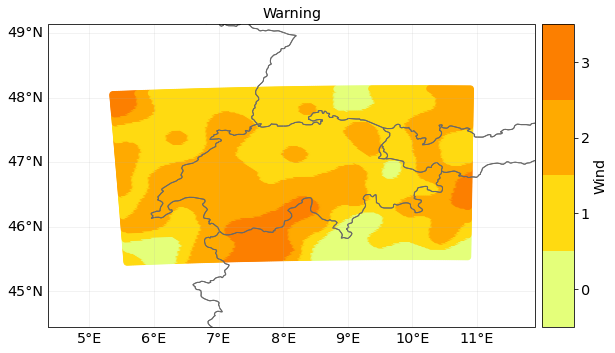

In [2]:
threshold = np.array([0.0, 19.44, 25.0, 30.55, 38.88, 300.0])

file_name = 'cosmo2_2019121400.nc'
file_name = '/Users/robertblass/Desktop/ETH/Masterarbeit/data/cosmo2_ch_1day_max_new/train/' + file_name

ncdf = xr.open_dataset(file_name)
wind_matrix = ncdf.VMAX_10M.values[0, :, :]

lon = ncdf.lon_1.values
lat = ncdf.lat_1.values
coord = np.vstack((lat.flatten(), lon.flatten())).transpose()

# no filtering operations applied - only thresholded as reference
threshold_only = Warn.from_np_array(wind_matrix, threshold, operations=[], sizes=[])
# default operations
warn = Warn.from_np_array(wind_matrix, threshold)

geo_scatter_categorical(threshold_only.warning.flatten(), coord, 'Wind', 'Thresholded Data', cmap='Wistia')
geo_scatter_categorical(warn.warning.flatten(), coord, 'Wind', 'Warning', cmap='Wistia')

array([<GeoAxesSubplot:title={'center':'Warning by Combination of Operations'}>],
      dtype=object)

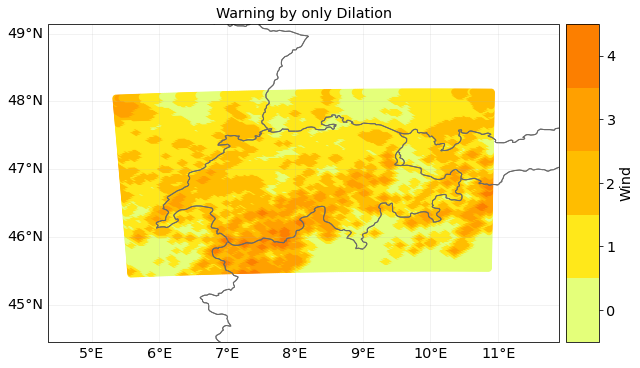

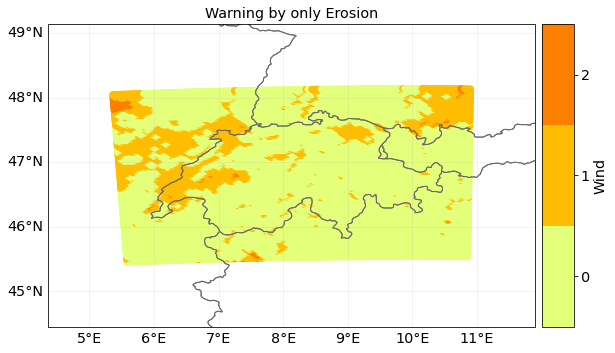

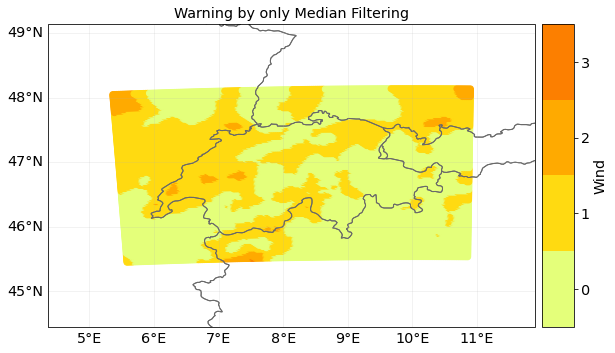

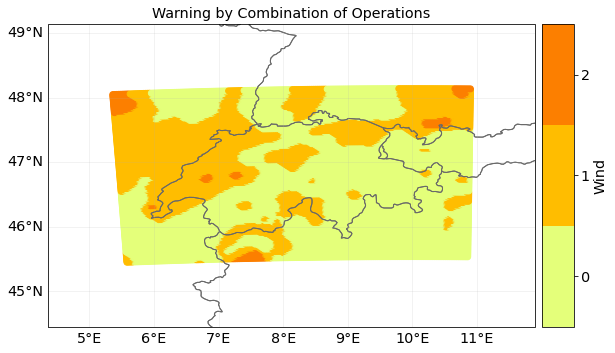

In [3]:
# select operations manually
# only dilation
warn_dilation_only = Warn.from_np_array(wind_matrix, threshold, operations=['DILATION'], sizes=[2])
# only erosion
warn_erosion_only = Warn.from_np_array(wind_matrix, threshold, operations=['EROSION'], sizes=[2])
# only median filtering
warn_median_only = Warn.from_np_array(wind_matrix, threshold, operations=['MEDIANFILTERING'], sizes=[10])

# first ersoion, then dilation, then median filtering
warn_combination = Warn.from_np_array(wind_matrix, threshold, operations=['EROSION', 'DILATION', 'MEDIANFILTERING'],
                         sizes=[2, 3, 10])

geo_scatter_categorical(warn_dilation_only.warning.flatten(), coord, 'Wind', 'Warning by only Dilation', cmap='Wistia')
geo_scatter_categorical(warn_erosion_only.warning.flatten(), coord, 'Wind', 'Warning by only Erosion', cmap='Wistia')
geo_scatter_categorical(warn_median_only.warning.flatten(), coord, 'Wind', 'Warning by only Median Filtering', cmap='Wistia')
geo_scatter_categorical(warn_combination.warning.flatten(), coord, 'Wind', 'Warning by Combination of Operations', cmap='Wistia')


array([<GeoAxesSubplot:title={'center':'Warning without Expansion'}>],
      dtype=object)

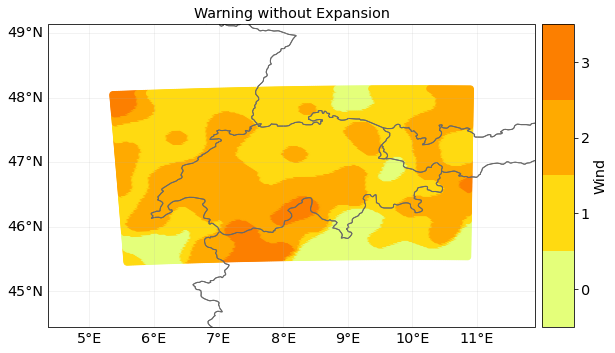

In [4]:
# Warning without expansion of regions of higher level
warn_wo_expand = Warn.from_np_array(wind_matrix, threshold, expand=False)

geo_scatter_categorical(warn_wo_expand.warning.flatten(), coord, 'Wind', 'Warning without Expansion', cmap='Wistia')

array([<GeoAxesSubplot:title={'center':'Warning removed Regions'}>],
      dtype=object)

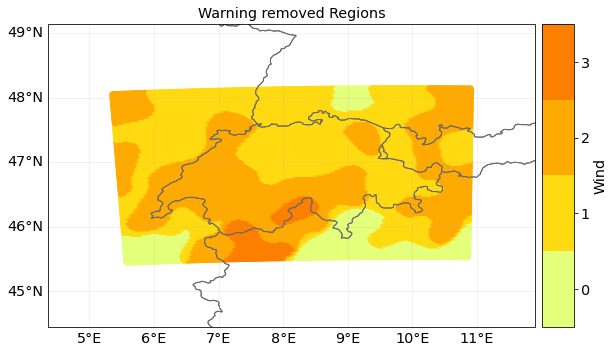

In [5]:
# Remove too small regions by setting threshold
threshold_too_small = 200
warn_removed = Warn.remove_small_regions(warn_wo_expand.warning, threshold_too_small)
geo_scatter_categorical(warn_removed.flatten(), coord, 'Wind', 'Warning removed Regions', cmap='Wistia')

# CLIMADA Impact Example - Haiti

In [6]:
from climada.util.api_client import Client
client = Client()

tc_dataset_infos = client.list_dataset_infos(data_type='tropical_cyclone')
client.get_property_values(tc_dataset_infos, known_property_values = {'country_name':'Haiti'})

{'res_arcsec': ['150'],
 'climate_scenario': ['rcp26', 'rcp45', 'rcp85', 'historical', 'rcp60'],
 'ref_year': ['2040', '2060', '2080'],
 'nb_synth_tracks': ['50', '10'],
 'spatial_coverage': ['country'],
 'tracks_year_range': ['1980_2020'],
 'country_iso3alpha': ['HTI'],
 'country_name': ['Haiti'],
 'country_iso3num': ['332']}

2022-04-06 11:44:30,001 - climada.hazard.base - INFO - Reading /Users/robertblass/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040/v1/tropical_cyclone_10synth_tracks_150arcsec_rcp45_HTI_2040.hdf5


array([<GeoAxesSubplot:title={'center':'Categorical Warning Map'}>],
      dtype=object)

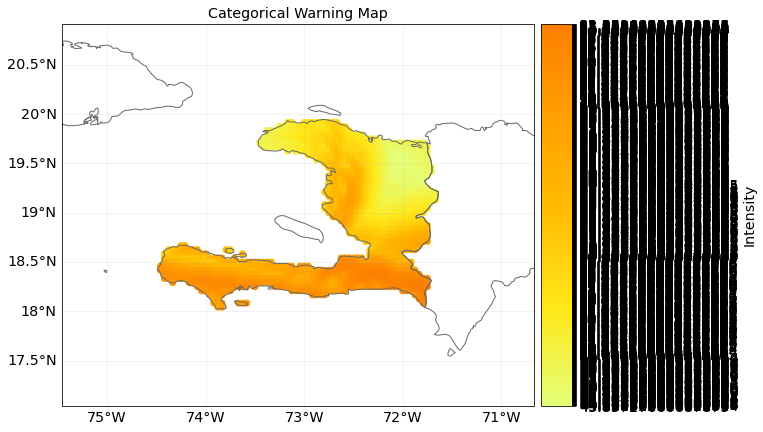

In [7]:
# Read hazard
tc_haiti = client.get_hazard('tropical_cyclone', properties={'country_name': 'Haiti', 'climate_scenario': 'rcp45', 'ref_year':'2040', 'nb_synth_tracks':'10'})
tc_haiti.intensity = sparse.csr_matrix(tc_haiti.intensity.max(axis=0))

lon = tc_haiti.centroids.lon
lat = tc_haiti.centroids.lat
coord = np.vstack((lat.flatten(), lon.flatten())).transpose()

geo_scatter_categorical(tc_haiti.intensity.todense().flatten(), coord, 'Intensity', 'Categorical Warning Map', cmap='Wistia')

In [8]:
# function to pad country shape with zeros to form rectangle (as needed by algorithm)
def zeropadding(lat, lon, val):
    lat = np.round(lat, decimals=9)
    lon = np.round(lon, decimals=9)
    
    un_y = np.sort(np.unique(lat))
    un_x = np.sort(np.unique(lon))

    y = lat
    y0 = min(y)
    dy = abs(un_y[1] - un_y[0])
    x = lon
    x0 = min(x)
    dx = abs(un_x[1] - un_x[0])

    i = ((y - y0) / dy).astype(int)
    j = ((x - x0) / dx).astype(int)
    grid = np.zeros((len(np.unique(lat)), len(np.unique(lon))))
    grid[i, j] = val
    
    xx, yy = np.meshgrid(un_x, un_y)
    coord = np.vstack((yy.flatten(), xx.flatten())).transpose()
    
    return grid, coord

array([<GeoAxesSubplot:title={'center':'Warning wihtout expanding regions'}>],
      dtype=object)

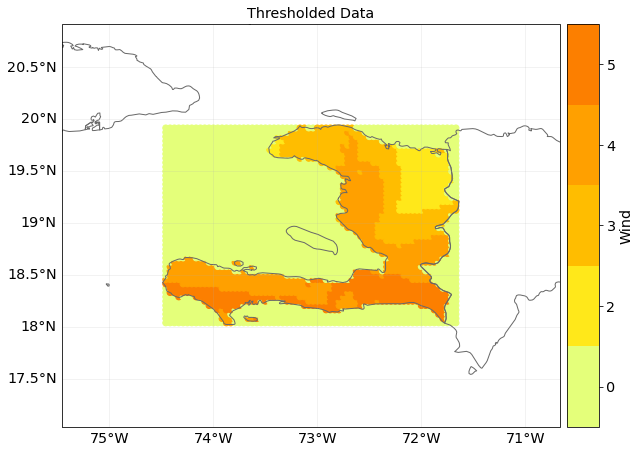

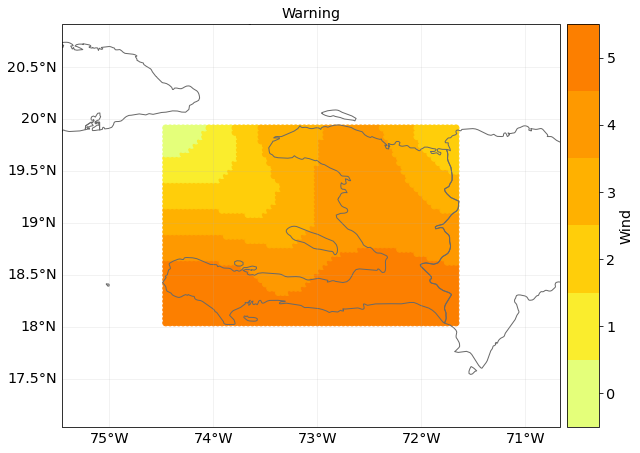

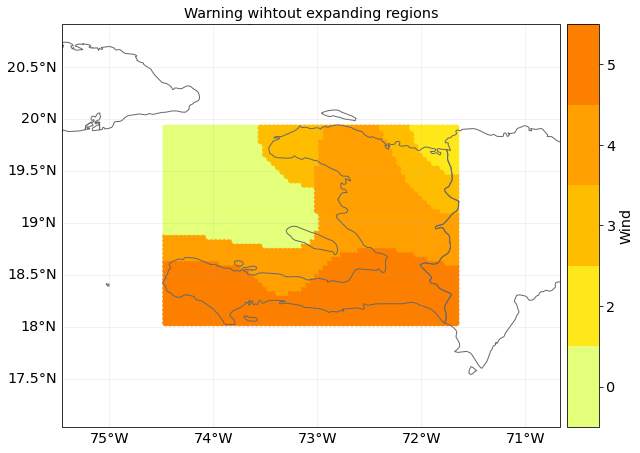

In [9]:
# Thresholds
threshold = [0, 30, 40, 50, 60, 70, 1000]
grid, coord = zeropadding(tc_haiti.centroids.lat, tc_haiti.centroids.lon, tc_haiti.intensity.todense()[0])
# no filtering operations applied - only thresholded as reference
threshold_only = Warn.from_np_array(grid, threshold, operations=[], sizes=[])
# default operations
warn_def = Warn.from_np_array(grid, threshold, True)
# no expanding
warn_no_exp = Warn.from_np_array(grid, threshold, False)

geo_scatter_categorical(threshold_only.warning.flatten(), coord, 'Wind', 'Thresholded Data', cmap='Wistia')
geo_scatter_categorical(warn_def.warning.flatten(), coord, 'Wind', 'Warning', cmap='Wistia')
geo_scatter_categorical(warn_no_exp.warning.flatten(), coord, 'Wind', 'Warning wihtout expanding regions', cmap='Wistia')

array([<GeoAxesSubplot:title={'center':'Removed regions'}>], dtype=object)

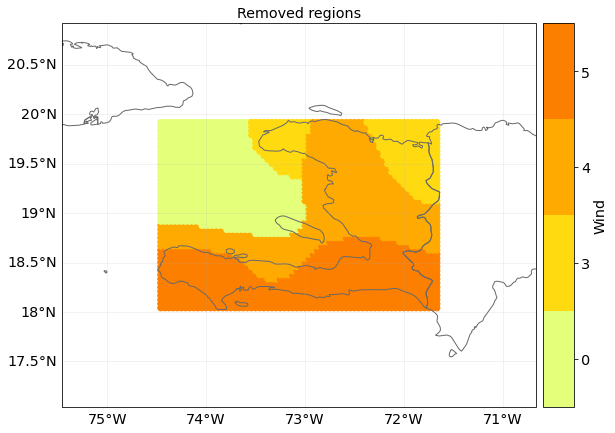

In [10]:
# remove too small regions
warning_removed = Warn.remove_small_regions(warn_no_exp.warning, 150)
geo_scatter_categorical(warning_removed.flatten(), coord, 'Wind', 'Removed regions', cmap='Wistia')

# Impact Example Haiti

In [11]:
exp_haiti = client.get_litpop_default(country="Haiti")

2022-04-06 11:44:49,988 - climada.entity.exposures.base - INFO - Reading /Users/robertblass/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v1/LitPop_150arcsec_HTI.hdf5


In [12]:
from climada.entity import ImpfTropCyclone, ImpactFuncSet

In [13]:
impf = ImpfTropCyclone().from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf)

/Users/robertblass/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


<GeoAxesSubplot:title={'center':"LitPop Exposure for ['HTI'] at 150 as, year: 2018, financial mode: pc,\nexp: [1, 1], admin1_calc: False"}>

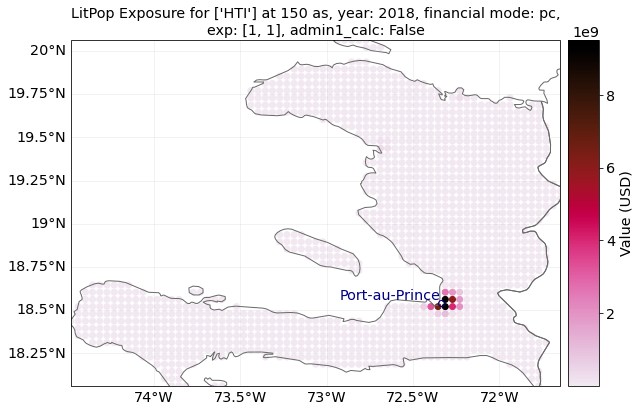

In [14]:
exp_haiti.plot_scatter()

In [15]:
lat, lon, values = exp_haiti.gdf.latitude.to_numpy(), exp_haiti.gdf.longitude.to_numpy(), exp_haiti.gdf.value.to_numpy()

In [16]:
grid, coord = zeropadding(lat, lon, values)

array([<GeoAxesSubplot:title={'center':'Impact Data'}>], dtype=object)

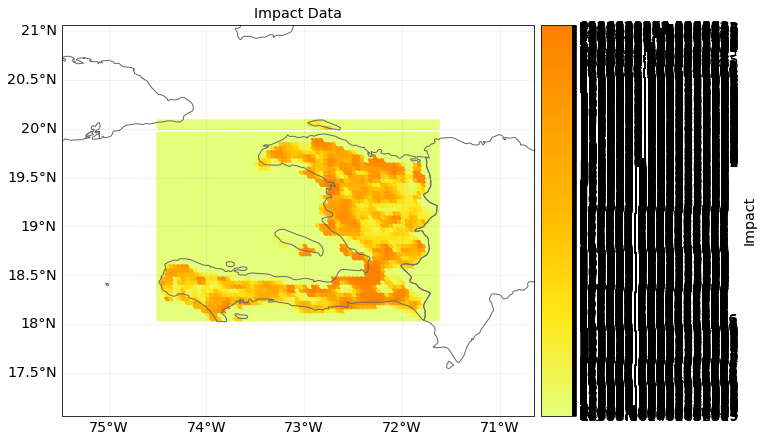

In [17]:
geo_scatter_categorical(grid.flatten(), coord, 'Impact', 'Impact Data', cmap='Wistia')

0.0   9510503293.986261


array([<GeoAxesSubplot:title={'center':'Impact Clustered'}>], dtype=object)

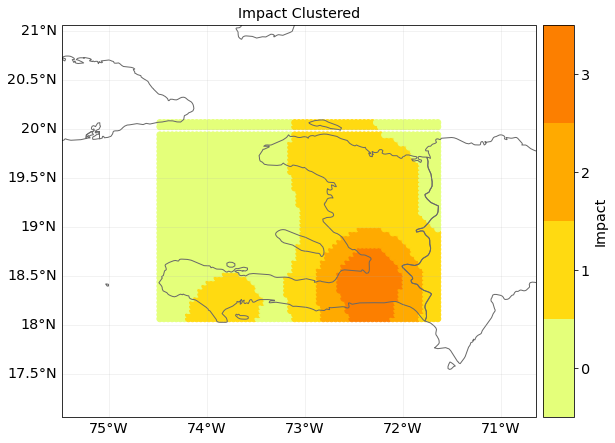

In [18]:
# default operations
threshold = [0, 1000000, 6000000, 10000000,   10000000000]
print(np.min(grid), ' ', np.max(grid))
warn_def = Warn.from_np_array(grid, threshold, True)

geo_scatter_categorical(warn_def.warning.flatten(), coord, 'Impact', 'Impact Clustered', cmap='Wistia')